In [1]:
from typing import List, Dict, Callable
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from tqdm import tqdm

## loss function
* sum of squares for error (SSE)
* cross entropy error (CEE)

### sum of squares for error (SSE)
$$ E=\frac{1}{2}\sum_{k}(y_{k}-t_{k})^2 $$

In [2]:
def sum_squares_error(y: npt.NDArray[np.float64], t: npt.NDArray[np.int32]) -> np.float64:
    return 0.5 * np.sum((y-t)**2)

In [3]:
# example-01 (The real value's index : 2, The most probable value's index : 2)
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]

sum_squares_error(np.array(y), np.array(t))

0.09750000000000003

In [4]:
# example-02 (The real value's index : 2, The most probable value's index : 7)
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

sum_squares_error(np.array(y), np.array(t))

0.5975

### cross entropy error (CEE)
$$ E = -\sum_{k}t_{k}\ln{y_{k}} $$

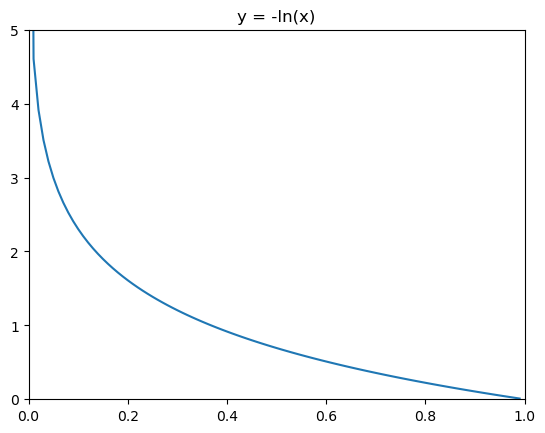

In [5]:
x = np.arange(0.0, 1.0, 0.01)
delta = 1e-7
y = -np.log(x + delta)
plt.plot(x, y)
plt.xlim(0.0, 1.0)
plt.ylim(0, 5)
plt.title('y = -ln(x)')
plt.show()

In [6]:
def cross_entropy_error(y: npt.NDArray[np.float64], t: npt.NDArray[np.int32]) -> np.float64: 
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [7]:
# example-01 (The real value's index : 2, The most probable value's index : 2)
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]

cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [8]:
# example-02 (The real value's index : 2, The most probable value's index : 7)
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

### mini batch

In [9]:
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [10]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [11]:
def mini_batch_cee(y: npt.NDArray[np.float64], t: npt.NDArray[np.int32]) -> npt.NDArray[np.float64]:
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### numerical differentiation

In [12]:
def numerical_diff(f: Callable[[npt.NDArray[np.float64]], npt.NDArray[np.float64]], x: np.float64) -> np.float64:
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

In [13]:
def function_1(x: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    return 0.01*x**2 + 0.1*x

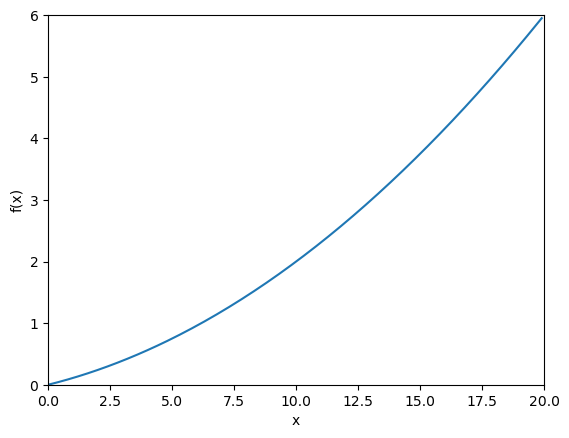

In [14]:
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)

plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.xlim(0, 20)
plt.ylim(0, 6)
plt.show()

In [15]:
print(numerical_diff(function_1, 5))
print(numerical_diff(function_1, 10))

0.1999999999990898
0.2999999999986347


In [16]:
def tangent_line(f: Callable[[npt.NDArray[np.float64]], npt.NDArray[np.float64]], 
                 x: np.float64) -> Callable[[npt.NDArray[np.float64]], npt.NDArray[np.float64]]:
    d = numerical_diff(f, x)
    y = f(x) - d*x
    return lambda t: d*t + y

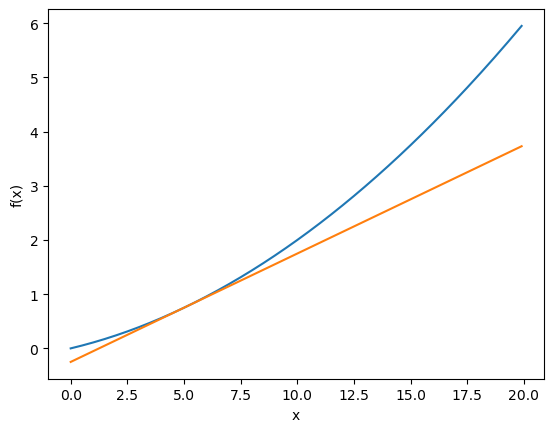

In [17]:
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()

In [18]:
def _numerical_gradient_no_batch(f: Callable[[npt.NDArray[np.float64]], np.float64], 
                       x: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        
        # calculate f(x+h)
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # calculate f(x-h)
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)

        # restore a value
        x[idx] = tmp_val
    
    return grad


def numerical_gradient(f: Callable[[npt.NDArray[np.float64]], np.float64], 
                       X:npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)

        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)

        return grad

In [19]:
def function_2(x: npt.NDArray[np.float64]) -> np.float64:
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)

In [20]:
print(numerical_gradient(function_2, np.array([3.0, 4.0])))
print(numerical_gradient(function_2, np.array([0.0, 2.0])))
print(numerical_gradient(function_2, np.array([3.0, 0.0])))

[6. 8.]
[0. 4.]
[6. 0.]


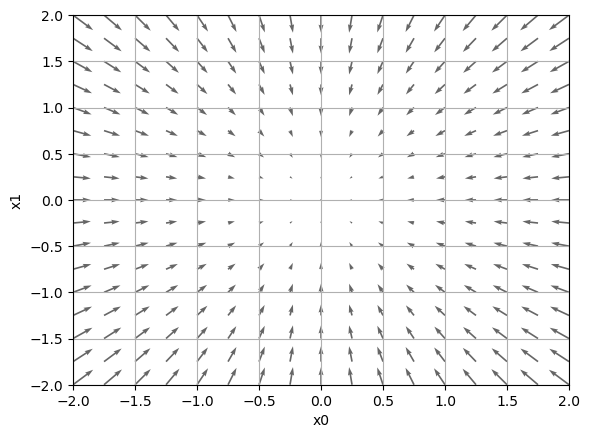

In [21]:
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]) )

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.draw()
plt.show()

### gradient descent method

In [22]:
def gradient_descent(f: Callable[[npt.NDArray[np.float64]], np.float64],
                     init_x: npt.NDArray[np.float64], 
                     lr:float=0.01, step_num:int=100) -> npt.NDArray[np.float64]:
    x = init_x
    x_history = [x]

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
        x_history.append(x.copy())

    return np.array(x_history)

In [23]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)[-1]

array([-6.11110793e-10,  8.14814391e-10])

In [24]:
# the example of a large learning rate
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100)[-1]

array([-2.58983747e+13, -1.29524862e+12])

In [25]:
# the example of a small learning rate
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100)[-1]

array([-2.99999994,  3.99999992])

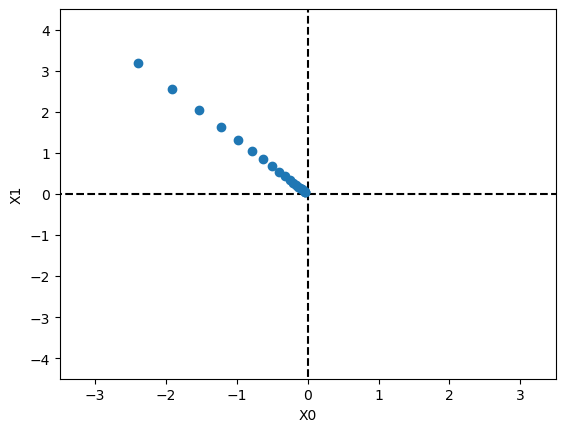

In [26]:
init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--k')
plt.plot( [0,0], [-5, 5], '--k')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

### mini batch training

In [50]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # initialize weight
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)


    def predict(self, x: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y


    def loss(self, x: npt.NDArray[np.float64], 
                   t:npt.NDArray[np.float64]) -> np.float64:
        y = self.predict(x)
        return cross_entropy_error(y, t)
    

    def accuracy(self, x: npt.NDArray[np.float64], 
                       t: npt.NDArray[np.float64]) -> np.float64:
        y = np.argmax(self.predict(x), axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    

    def numerical_gradient(self, x: npt.NDArray[np.float64], 
                       t: npt.NDArray[np.float64]) ->  Dict:
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

In [ ]:
# ⚠️ WARNING : Too much training time in a CPU-only environment!
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 3000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in tqdm(range(iters_num)):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.numerical_gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate *grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        print(f"✨ Epoch cnt : {epoch_cnt}")
        epoch_cnt += 1
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
        print("---------------------------------------------------")